# 1. Install Dependencies and Setup

In [9]:
!pip install tensorflow[and-cuda] opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 7.8 MB/s eta 0:00:0000:0100:01


In [10]:
###Check appropriate set up - should have tensorflow and cuda installed successfully. 
!pip list

Package                      Version
---------------------------- -------------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
blinker                      1.4
certifi                      2024.2.2
charset-normalizer           3.3.2
comm                         0.2.2
command-not-found            0.3
contourpy                    1.2.1
cryptography                 3.4.8
cycler                       0.12.1
dbus-python                  1.2.18
debugpy                      1.8.1
decorator                    5.1.1
distro                       1.7.0
distro-info                  1.1+ubuntu0.1
easyocr                      1.7.1
exceptiongroup               1.2.1
executing                    2.0.1
filelock                     3.13.4
flatbuffers                  24.3.25
fonttools                    4.51.0
fsspec                       2024.3.1
gast                         0.5.4
google-pasta                 0.2.0
grpcio                       

In [ ]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

os.path.join('image_data', 'pcr_neg')

###check directory is set up correctly
os.listdir('image_data/pcr_neg')

# 2. Image file processing

In [23]:
####set up directory 
data_dir = 'image_data' 
os.listdir(data_dir)

['pcr_neg', 'pcr_pos']

In [22]:
image_exts = ['jpeg','jpg']
image_exts

['jpeg', 'jpg']

# 3. Load Data

In [59]:
###batches, resizes etc 
data = tf.keras.utils.image_dataset_from_directory('image_data')

Found 158 files belonging to 2 classes.


In [60]:
###convert into numpy iterator (pulls and access from data pipeline generator)
data_iterator = data.as_numpy_iterator()

In [61]:
##pulls batches from pipeline
batch = data_iterator.next()

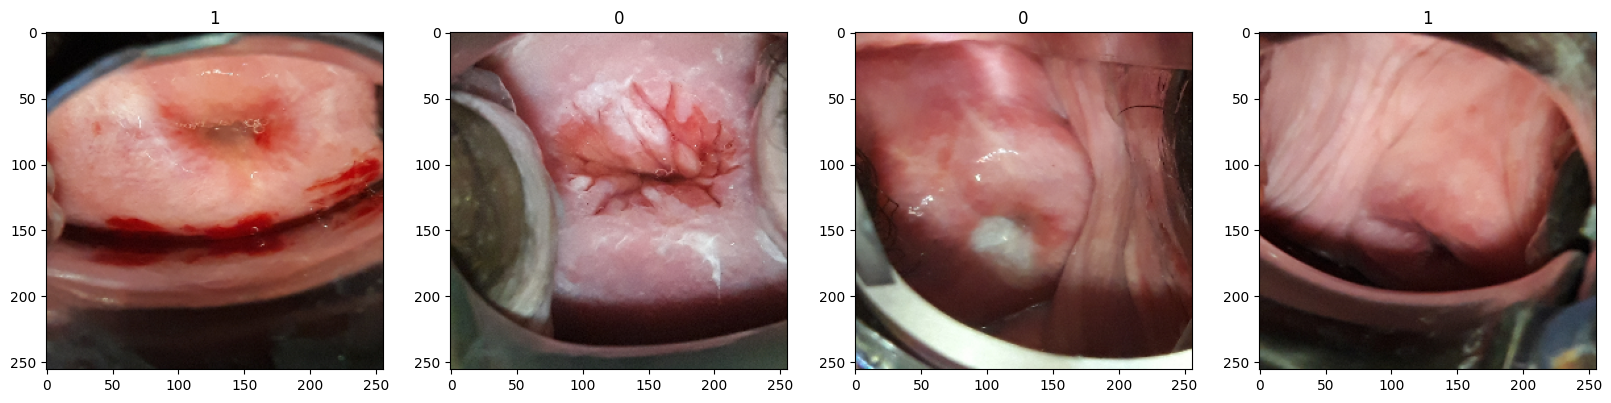

In [62]:
##check which class is assigned to which image type
###Class 0 is negative
###Class 1 is positive 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Preprocessing and scaling

In [63]:
###when data is loaded in it is at a 255 scale, but this scales to between 0 and 1 
##Careful not to run more than once as it will continue to divide
data = data.map(lambda x,y: (x/255, y))

In [64]:
data.as_numpy_iterator().next()

(array([[[[0.8458525 , 0.6693819 , 0.6487745 ],
          [0.84142154, 0.66495097, 0.6431373 ],
          [0.8461129 , 0.6617992 , 0.6382698 ],
          ...,
          [0.5238702 , 0.30034083, 0.26504672],
          [0.51231617, 0.28878677, 0.25349265],
          [0.49981618, 0.27185586, 0.23627834]],
 
         [[0.80606234, 0.607958  , 0.59663373],
          [0.8017272 , 0.60611594, 0.5921569 ],
          [0.8016544 , 0.6028799 , 0.5935662 ],
          ...,
          [0.5195887 , 0.307824  , 0.2686083 ],
          [0.5116919 , 0.29195005, 0.26159236],
          [0.5012906 , 0.2753102 , 0.24908471]],
 
         [[0.7835095 , 0.55726486, 0.54264706],
          [0.7690985 , 0.5416475 , 0.53380436],
          [0.7607843 , 0.55255055, 0.5370596 ],
          ...,
          [0.51550245, 0.29197302, 0.25498623],
          [0.5150927 , 0.29156327, 0.2641123 ],
          [0.4862745 , 0.25882354, 0.24313726]],
 
         ...,
 
         [[0.93829656, 0.9979243 , 0.9736251 ],
          [0.89485

# 5. Split Data for test, train etc

In [65]:
##check number of batches in dataset
len(data)

5

In [75]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [76]:
###make sure this equals your total number of batches. 
test_size+train_size+val_size

5

In [77]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Model brain

In [82]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [84]:
model = Sequential()

In [85]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/home/morganlemin/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [86]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [88]:
logdir='logs'

In [89]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

# 8. Plot Performance

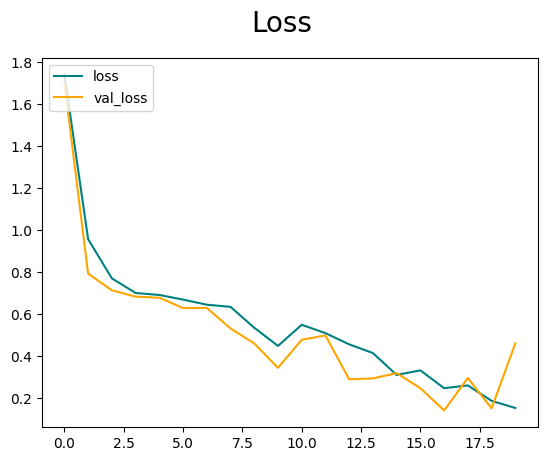

In [91]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

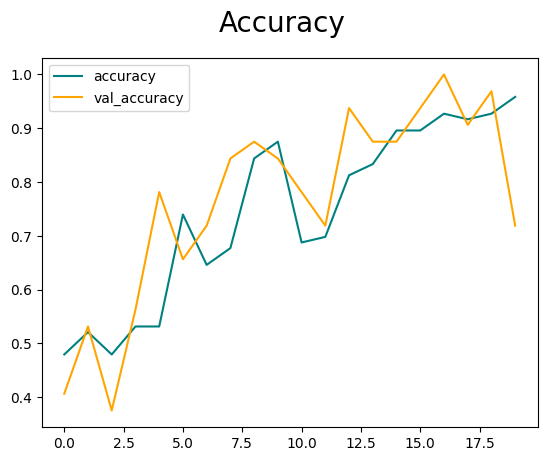

In [92]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [93]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [94]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [95]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-05-21 16:53:53.505124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [96]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.53333336, shape=(), dtype=float32) tf.Tensor(0.76666665, shape=(), dtype=float32)


# 10. Test

In [ ]:
###find all pathnames in the test batch
import pathlib

# Convert the test dataset into a list of file paths
test_data_dir = pathlib.Path(data_dir)
test_image_paths = list(test_data_dir.glob('**/*.jpg'))

# Ensure that only test dataset images are considered
test_image_paths = [str(path) for path in test_image_paths if 'pcr_neg' in str(path) or 'pcr_pos' in str(path)]

# Display all image paths in the test data set
for path in test_image_paths:
    print(path)


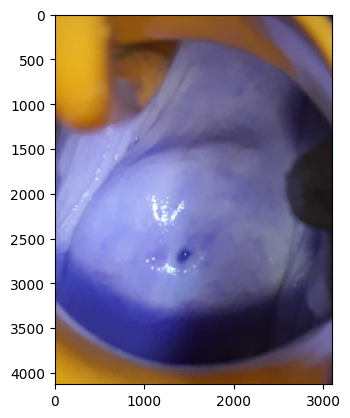

In [957]:
img = cv2.imread('image_data/pcr_neg/82bf2cc4-1d1a-4a7a-a5e5-8d79f502e55a.jpg')
plt.imshow(img)
plt.show()

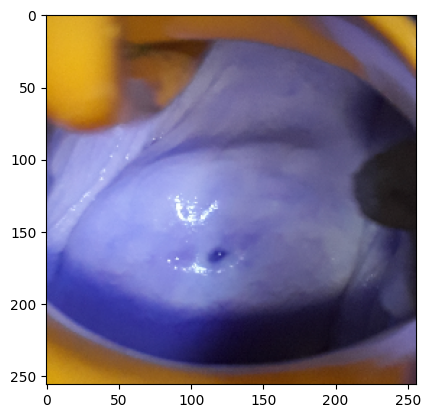

In [958]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [959]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [960]:
yhat

array([[0.7928481]], dtype=float32)

In [961]:
if yhat > 0.5: 
    print(f'Predicted class is PCR positive')
else:   
    print(f'Predicted class is PCR negative')

Predicted class is PCR positive


# 11. Save the Model

In [122]:
from tensorflow.keras.models import load_model

In [127]:
model.save(os.path.join('models','binaryPCRclassifier.h5'))

In [ ]:
new_model = load_model('binaryPCRclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))